# GJ 581 analysis

### Set up python environment

Change <tt>sys.path.insert()</tt> to include the directory where the <tt>NWelch</tt> source code resides on your system.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle

import sys
sys.path.insert(0, '/Users/sdr/NWelch/src/')

import TimeSeries
import Bivariate as Bi

### Read and inspect data

In [2]:
data = pd.read_csv('GJ581_Robertson14.txt', delim_whitespace=True, comment='#')
data

,BJD-2450000,Halpha,eHalpha,NaD,eNaD,RV,eRV
0,3152.712894,0.08064,0.00104,0.06131,0.00199,-10.25,1.1
1,3158.663460,0.08080,0.00105,0.06627,0.00198,-19.05,1.3
2,3511.773341,0.08054,0.00104,0.06923,0.00186,-7.25,1.2
3,3520.744746,0.08033,0.00103,0.06699,0.00187,10.35,1.4
4,3573.512039,0.07965,0.00110,0.06574,0.00209,0.65,1.3
...,...,...,...,...,...,...,...
233,5690.739963,0.08166,0.00108,0.06031,0.00204,-1.15,1.6
234,5691.692500,0.08241,0.00105,0.06247,0.00209,-11.95,1.4
235,5692.711935,0.08201,0.00108,0.06362,0.00202,-12.75,1.2
236,5693.756575,0.08151,0.00105,0.06438,0.00196,-2.25,1.0


### Before computing magnitude-squared coherence, I always take a quick look at each time series individually

### Create <tt>TimeSeries</tt> objects that hold H$\alpha$ and RV data

See <tt>demo/TimeSeries_demo.ipynb</tt> for more information on <tt>TimeSeries</tt> objects

In [3]:
ha = TimeSeries.TimeSeries(data['BJD-2450000'].to_numpy(), data['Halpha'].to_numpy())
rv = TimeSeries.TimeSeries(data['BJD-2450000'].to_numpy(), data['RV'].to_numpy(), display_frequency_info=False)

Nyquist frequency from mean dt: 0.04660
Nyquist frequency from 10% trimmed mean dt: 0.11465
Nyquist frequency from 20% trimmed mean dt: 0.15577
Nyquist frequency from median dt: 0.25901
Rayleigh resolution: 0.00039


### Plot the H$\alpha$ and RV time series and the histogram of timesteps $\Delta t_i$

The timestep histogram can help you decide on an appropriate Nyquist-like frequency. Recall that there is no true Nyquist frequency for unevenly spaced data, so you have to decide on the maximum frequency you wish to probe. I often use 1/median($\Delta t_i$). Fortunately we're not going to try and invert the NFFT, so your choice of Nyquist-like frequency won't produce adverse consequences at a later stage of analysis. 

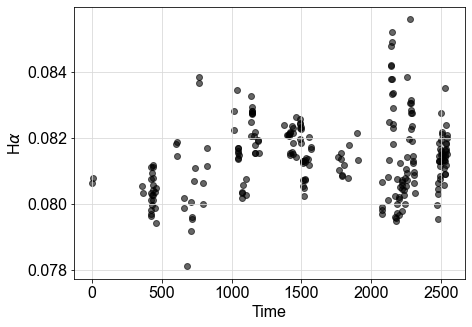

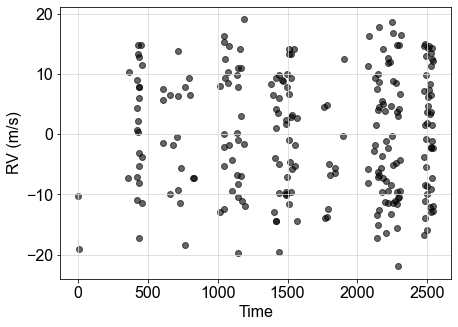

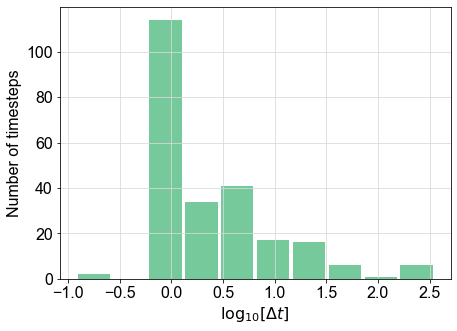

In [4]:
ha.scatterplot(ylabel=r"H$\alpha$")
rv.scatterplot(ylabel="RV (m/s)")
rv.dthist()

### Construct frequency grids, compute NFFTs and periodograms of H$\alpha$ and RV data

I chose a Nyquist-like frequency of 0.2 cycles/day because it encompasses all reported "planets" in the dataset and it's close to 1/median($\Delta t_i$).

In [5]:
ha.frequency_grid(0.2)
rv.frequency_grid(0.2)

ha.pow_FT(N_bootstrap=2000)
rv.pow_FT(N_bootstrap=2000)

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 0
Iteration 500
Iteration 1000
Iteration 1500


### Plot the periodograms

Vertical lines mark the rotation period on the H$\alpha$ periodogram and planets b and c on the RV periodogram. The rotation period of 132 days is what we have measured from this analysis. The previous rotation period estimate from <a href="https://ui.adsabs.harvard.edu/abs/2014Sci...345..440R/abstract">Robertson et al. (2014)</a> is 130 days. The y-axis scale defaults to log10, but you can set <tt>yscale='linear'</tt> if you must.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


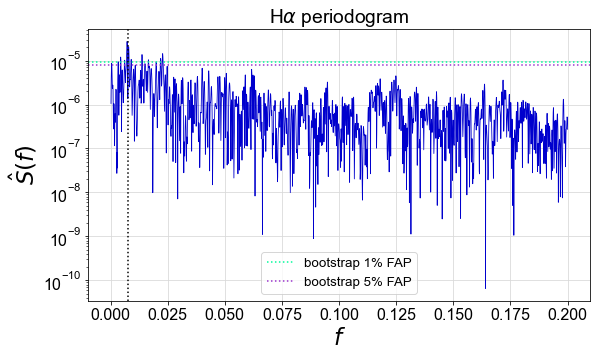

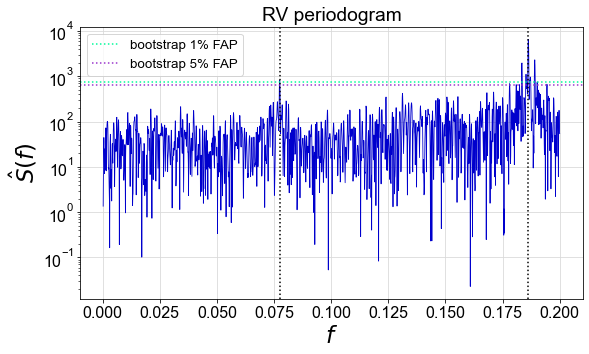

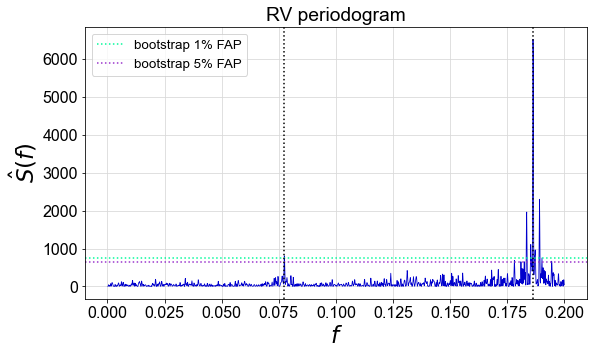

In [6]:
pb = 5.3686 # days
pc = 12.914
prot = 132
planets = [1/pb, 1/pc]
rotation = [1/prot]

ha.powplot(title=r"H$\alpha$ periodogram", vlines=rotation)
rv.powplot(title='RV periodogram', vlines=planets)
rv.powplot(title='RV periodogram', vlines=planets, yscale='linear')

### Deploy Siegel's test for periodicity

See section 3.7 of the accompanying paper for more on Siegel's test. Here we use the conservative implementation with $\lambda = 0.6$, which is optimized for two periodic signals. Test for three periodicities by using keyword <tt>tri=True</tt>, which will set $\lambda = 0.4$.

The null hypothesis of white noise is rejected for false-alarm risk $\alpha = 0.05$.

In [7]:
rv.Siegel_test()
ha.Siegel_test()

T statistic: 0.16326
T threshold for rejecting white noise hypothesis at 5% level: 0.00417
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities
T statistic: 0.06181
T threshold for rejecting white noise hypothesis at 5% level: 0.00417
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Start the coherence analysis

### Create the <tt>Bivariate</tt> object

If you read your data into a <tt>pandas</tt> dataframe, you need to use <tt>.to_numpy()</tt> in the <tt>Bivariate</tt> class constructor.

In [8]:
rv_ha = Bi.Bivariate(data['BJD-2450000'].to_numpy(), data['RV'].to_numpy(), 
                     data['Halpha'].to_numpy())

Nyquist frequency from mean dt: 0.04660
Nyquist frequency from 10% trimmed mean dt: 0.11465
Nyquist frequency from 20% trimmed mean dt: 0.15577
Nyquist frequency from median dt: 0.25901
Rayleigh resolution: 0.00039


### Set up the Welch's segmenting and tapering scheme

See sections 3.1 and 3.3 of the accompanying paper for more on segmenting and tapering. If you specify an integer number of segments instead of constructing the segments by hand (see <tt>demo/TimeSeries_demo.py</tt> for a more complete description of segmenting), the program will tell you how many data points per segment you have so you can make a good decision about your bias vs. variance tradeoff.

You also get information on the Rayleigh resolution and the power spectrum resolution unit, which is the width of the main lobe of the spectral window. Here we use "bandwidth" as convenient shorthand for width of main lobe of spectral window, with the understanding that our spectral windows are not truly bandlimited.

If decide to use tapers, it's a good idea to set <tt>plot_windows=True</tt> so you get a plot of each taper. If the tapers don't look bell-shaped (i.e. big chunks of the bell are missing), it's not a good idea to taper. These tapers are not too bad. Tapering decreases your spectral resolution but helps suppress variance (see sections 3.3 and 3.6 of the accompanying paper). For planet hunting, I usually prefer low variance to high resolution.

Number of data points per segment: 119
Number of segments: 3
Segment start and end points: [[  0 119]
 [ 59 178]
 [118 238]]
Effective number of segments: 2.994235
Frequency grid spacing: 0.000095
Minimum 6-dB main lobe half width: 0.001542
Mean 6-dB main lobe half width (1/2 resolution limit): 0.002482
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.000567


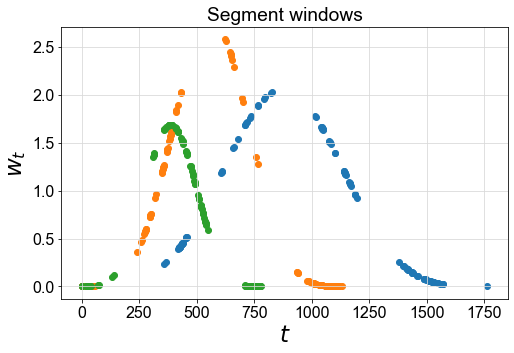

In [9]:
rv_ha.segment_data(3, 0.2, oversample=6, window='BlackmanHarris', plot_windows=True)

### Calculate the RV-H$\alpha$ coherence estimate and Welch's power spectrum estimates, then get bootstrap false alarm levels

<tt>NWelch</tt> always computes analytical false alarm levels on coherence estimates, but these are calculated against a background level of zero coherence. If there's a broad-spectrum process that manifests in both time series (e.g. turbulence), the assumption of zero background coherence is incorrect and you could get misleading false alarm levels. The bootstrap FALs are there as a failsafe for when the analytical FALs fail. In practice, however, I haven't seen this happen; usually the analytical and bootstrap FALs match very well. (And bootstrap has its own failure modes, e.g. <a href="https://ui.adsabs.harvard.edu/abs/2008MNRAS.385.1279B/abstract">Baluev (2008)</a>, <a href="https://academic.oup.com/mnras/article/466/4/4250/2769503">Littlefair et al. (2016)</a>, <a href="https://onlinelibrary.wiley.com/doi/book/10.1002/9780470192573">Chernick (2007)</a>.) The default number of bootstrap iterations is 10000. You can change this with the <tt>N_coh_bootstrap</tt> keyword.

By default, all Welch's segments have a linear trend removed before their Fourier transforms are calculated. I recommend linear detrending, but you can disable it by setting <tt>trend=False</tt> in <tt>Welch_coherence_powspec()</tt>. You can also do quadratic detrending by setting <tt>trend_type='quadratic'</tt> (default is <tt>trend_type='linear'</tt>). The quadratic detrending feature is relatively untested. We think it could be useful when a segment contains a long-term nonlinear trend; those trends should land in the zero-frequency power spectrum bin, but in reality they leak power into higher frequencies and bias the power spectrum estimate. However, we haven't done any rigorous statistical analysis on quadratic detrending, and it could remove real signal. Use at your own risk.

<tt>Welch_coherence_powspec_bootstrap()</tt> counts false alarm level crossings per Rayleigh resolution unit. Right now these aren't used in any subsequent calculations, but they may become important in future extensions of <tt>NWelch</tt>.

In [10]:
rv_ha.Welch_coherence_powspec()
rv_ha.Welch_coherence_powspec_bootstrap()

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500


### Use Siegel's test on the Welch's power spectrum estimates

Sxx is the Welch's power spectrum of series x, Syy is the Welch's power spectrum of series y. <tt>Bivariate.Siegel_Welch()</tt> is actually just a wrapper of <tt>TimeSeries.Siegel_test(Welch=True)</tt>.

As expected, the Welch's power spectrum estimates support the hypothesis that both time series are periodic.

In [11]:
rv_ha.Siegel_Welch()

Siegel's test on Sxx:
T statistic: 0.07755
T threshold for rejecting white noise hypothesis at 5% level: 0.00406
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities
Siegel's test on Syy:
T statistic: 0.02121
T threshold for rejecting white noise hypothesis at 5% level: 0.00406
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot the transformed magnitude-squared coherence estimate $z(f)$

See Equation 15 of the accompanying paper. I always use $z(f)$ instead of $C^{\prime \; 2}_{xy}(f)$ for actual analysis because it turns the closed $[0,1]$ scale into an open $[0,\infty]$ scale, which magnifies the difference between highly significant signals with $C^{\prime \; 2}_{xy}(f) \rightarrow 1$. On a plot of $z(f)$, you can unambiguously tell which signals cross the 0.1% FAL.

Black vertical lines are at the frequencies of "planets" d and g and the star rotation period, which we measured as 132 days (section 4.1 of the accompanying paper). d and g are actually rotation harmonics. If you want your legend to be less crowded, leave out <tt>show_theoretical_thresholds=True</tt> from your call to <tt>coh_plot</tt> (the default is <tt>show_theoretical_thresholds=False</tt>). You could also leave out the bootstrap false alarm thresholds by setting <tt>show_boot_thresholds=False</tt> (default is to include them if they have been calculated). I always make at least one plot that shows both sets of false alarm thresholds just as a sanity check. Possible to-do for me: put the legend on the outer right of the plot.

Here I added by hand a mint-green vertical line at the 4th rotation harmonic ($5 f_{\rm rot}$) just to emphasize the strength of that signal. To get a gray vertical line, I could have eliminated the extra call to <tt>plt.axvline()</tt> and just included $5 f_{\rm rot}$ in the <tt>stellar_signals</tt> list.

All plots show the debiased coherence estimate. You can change the linewidth of the coherence series with the keyword <tt>lw</tt>. Default is 0.8.

Based on our preliminary analysis, coherence RV-activity indicator signals at high-order rotation harmonics seems to be a pattern. I hope a stellar physicist will follow that line of inquiry. The point of our (already very long) accompanying paper was to introduce the magnitude-squared coherence statistic and the Welch's estimator, so we didn't go too deeply into the stellar physics.

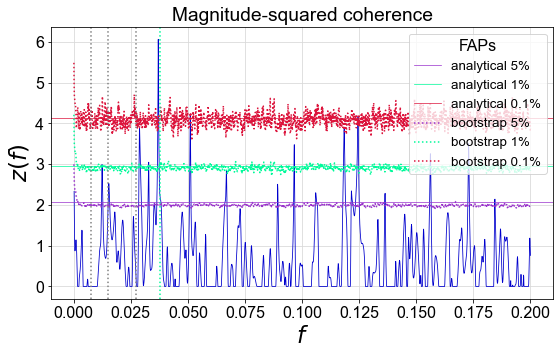

In [12]:
pd = 66
pg = 36.5
stellar_signals = [1/prot, 1/pd, 1/pg]
rv_ha.coh_plot(show_theoretical_thresholds=True, vlines=stellar_signals)
plt.axvline(5/prot, color='mediumspringgreen', ls=':') # added by hand

### Plot the non-transformed coherence estimate $\hat{C}^{\prime \; 2}_{xy}(f)$

Same function call as above, just add the keyword <tt>transformed=False</tt>. 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


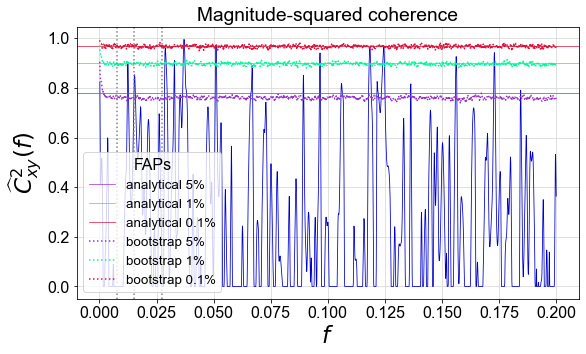

In [13]:
rv_ha.coh_plot(show_theoretical_thresholds=True, transformed=False, vlines=stellar_signals)

### Examine the Welch's spectral window

Since a <tt>Bivariate</tt> object stores the data in two <tt>TimeSeries</tt> objects, <tt>x_series</tt> and <tt>y_series</tt>, you have access to all the <tt>TimeSeries</tt> methods. Here we use <tt>TimeSeries.spectral_window_Welch()</tt> to sanity-check our Welch's spectral window and make sure it has no huge sidelobes that can easily be misinterpreted as periodic signals.

Both <tt>TimeSeries.spectral_window_Welch()</tt> and <tt>TimeSeries.spectral_window()</tt>, which works on the Lomb-Scargle periodogram, print out the empirically measured half-bandwidth $\mathcal{B}$ of the power spectrum estimator (see section 3.6 of the accompanying paper), defined by the -6 deciBel decrease in the main lobe amplitude of the spectral window (<a href="https://www.scp.byu.edu/docs/pdf/Harris1978windows.pdf">Harris 1978</a>). The resolution unit is $2\mathcal{B}$. Note that our shorthand use of the word "bandwidth" doesn't imply that the spectral window is truly bandlimited.

You can save your spectral window to a file by adding the keyword argument <tt>outfile="filename.txt"</tt>. If you just want to calculate the spectral window, but not plot it, you can set <tt>plot=False</tt>. A linear y-axis is available with <tt>yscale='linear'</tt>, though the log10 version is strongly preferred for the spectral window plot.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Half bandwidth: 0.003220
Welch average spectral window not saved to file
Half bandwidth: 0.003220
Welch average spectral window not saved to file


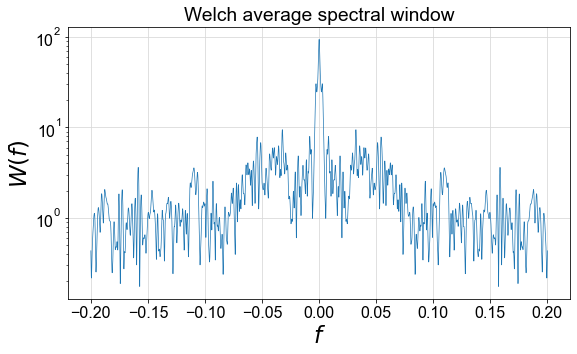

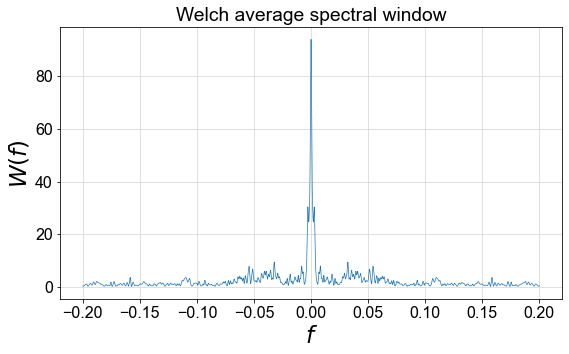

In [14]:
rv_ha.x_series.spectral_window_Welch()
rv_ha.x_series.spectral_window_Welch(yscale='linear')

### Plot both Welch's power spectrum estimates

Top: RV, bottom: H$\alpha$. <tt>Bivariate.Welch_pow_plot()</tt> is a wrapper of <tt>TimeSeries.powplot(Welch=True)</tt>. To plot the Welch power spectrum of <tt>y_series</tt> (H$\alpha$ in this case), set <tt>x_or_y='y'</tt> (default is <tt>x_or_y='x'</tt>). Recall that the <tt>stellar_signals</tt> list contains the rotation period and "planets" d and g. g is actually the 3rd rotation harmonic ($4 f_{\rm rot}$). It doesn't show up as a statistically significant peak in the Welch's H$\alpha$ periodogram, but it's very clear in the coherence estimate. Meanwhile, you can see $> 99$% statistically significant (according to the bootstrap thresholds) peaks at $2 f_{\rm rot}$ and $3 f_{\rm rot}$.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


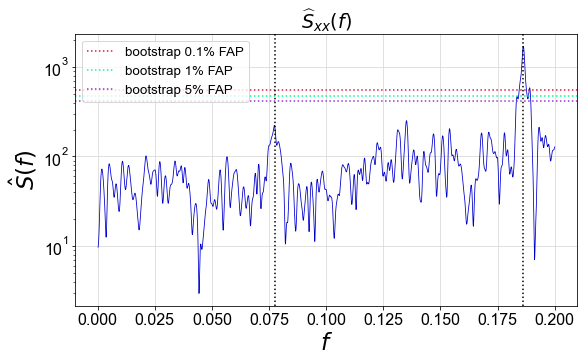

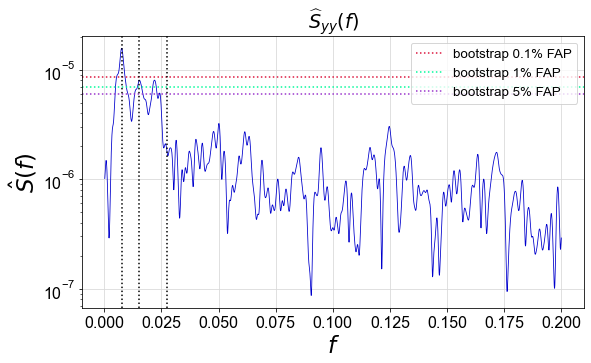

In [15]:
rv_ha.Welch_pow_plot(vlines=planets)
rv_ha.Welch_pow_plot(x_or_y='y', vlines=stellar_signals)

### Plot RV power spectrum with a linear y-axis

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


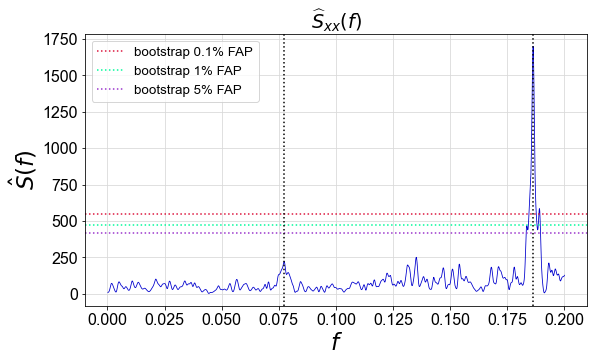

In [16]:
rv_ha.Welch_pow_plot(vlines=planets, yscale='linear')

### Calculate <tt>astropy.timeseries.LombScargle</tt> periodograms from both time series

Here we specify the same frequency grid as in the previous analysis and use the power spectral density normalization so we can compare with the <tt>NWelch</tt> results, all of which are psd normalized. The zero frequency is responsible for the invalid value warning.

In [17]:
pow_ha = LombScargle(data['BJD-2450000'].to_numpy(), data['Halpha'].to_numpy(), normalization='psd').power(rv_ha.pow_coh_grid)
pow_rv = LombScargle(data['BJD-2450000'].to_numpy(), data['RV'].to_numpy(), normalization='psd').power(rv_ha.pow_coh_grid)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Rotation period measurement

Based on the highest peak in the H$\alpha$ Welch's periodogram, which is extremely statistically significant. The great thing about the Welch's estimator is that the spectral windows come out a lot smoother than the generalized Lomb-Scargle spectral windows, so it's much easier to correctly identify the frequency of any oscillation (see Figures 9 and 12 of the accompanying paper). I used this new rotation period measurement in all H$\alpha$ periodograms and Welch's power spectra shown above.

In [18]:
frot_measured = rv_ha.y_series.Welch_powgrid[np.argmax(rv_ha.y_series.Welch_pow)]
print('Measured rotation period:', 1/frot_measured)

Measured rotation period: 132.0000000000001


### Nice plot of $z(f)$ for paper (Figure 13)

All <tt>NWelch</tt> variables are public. This is mostly intended as a feature: if you want to do some math that's not part of the <tt>NWelch</tt> functionality, it's easy to access whatever variable you need. It's also a hack that deals with the plotting routines in <tt>NWelch</tt> not yet being sophisticated enough to always produce publication-quality plots. <tt>Bivariate.coh_plot()</tt> and <tt>TimeSeries.powplot()</tt> need more customizability, like where the legend is placed, how thick the vertical lines should be, ability to shade the bandwidth, flexible x-axis labels etc. 

Text(0.5, 1.0, 'GJ 581: $x_t = I_{H_{\\alpha}}, y_t = $RV')

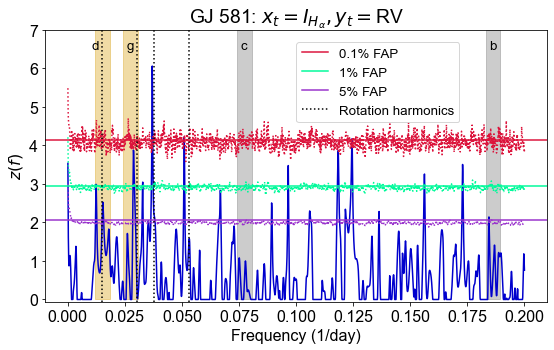

In [19]:
band = 0.00322

fig, ax = plt.subplots(1, 1, figsize=(9,5))
ax.plot(rv_ha.pow_coh_grid, rv_ha.coh_transformed, color='mediumblue')
ax.plot(rv_ha.pow_coh_grid, rv_ha.coh_transformed_boot_5, color='darkorchid', ls=':')
ax.plot(rv_ha.pow_coh_grid, rv_ha.coh_transformed_boot_1, color='mediumspringgreen', ls=':')
ax.plot(rv_ha.pow_coh_grid, rv_ha.coh_transformed_boot_01, color='crimson', ls=':')
ax.axhline(Bi.ztrans(rv_ha.coh_prob_01, rv_ha.Nseg_eff), color='crimson', label='0.1% FAP')
ax.axhline(Bi.ztrans(rv_ha.coh_prob_1, rv_ha.Nseg_eff), color='mediumspringgreen', label='1% FAP')
ax.axhline(Bi.ztrans(rv_ha.coh_prob_5, rv_ha.Nseg_eff), color='darkorchid', label='5% FAP')
for s in [1/pd, 1/pg]:
    ax.fill_between([s-band, s+band], [0,0], [7,7], color='goldenrod', alpha=0.4)
for p in planets:
    ax.fill_between([p-band, p+band], [0,0], [7,7], color='gray', alpha=0.4)
ax.set_xlabel('Frequency (1/day)')
ax.set_ylabel(r"$z(f)$")
ax.set_ylim([-0.06, 7])
ax.axvline(4/prot, color='k', ls=':', label='Rotation harmonics')
ax.axvline(5/prot, color='k', ls=':')
ax.axvline(7/prot, color='k', ls=':')
ax.axvline(2/prot, color='k', ls=':')
ax.legend(fontsize='small', loc=(0.5,0.66))
ax.text(planets[0]-band/2, 6.5, 'b', color='k', fontsize='small')
ax.text(planets[1]-band/2, 6.5, 'c', color='k', fontsize='small')
ax.text(stellar_signals[1]-1.5*band, 6.5, 'd', color='k', fontsize='small')
ax.text(stellar_signals[2]-band/2, 6.5, 'g', color='k', fontsize='small')
ax.set_title(r"GJ 581: $x_t = I_{H_{\alpha}}, y_t = $RV")

### Nice plot of Welch's power spectrum estimates, with Lomb-Scargle included for comparison

This is a slight alteration to Figure 11 of the accompanying paper. To do: outer right legend.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


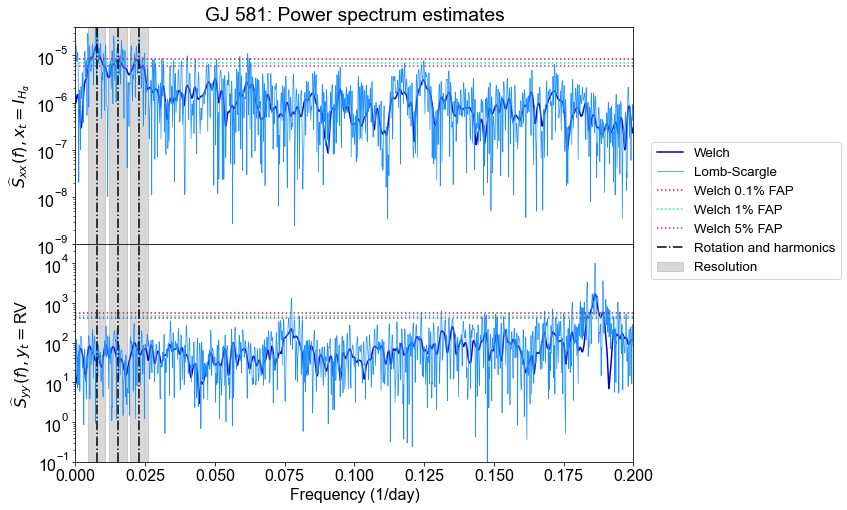

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))

ax1.semilogy(rv_ha.pow_coh_grid, rv_ha.y_series.Welch_pow, color='mediumblue', label='Welch')
ax1.semilogy(rv_ha.pow_coh_grid, pow_ha, color='dodgerblue', lw=0.7, label='Lomb-Scargle')
ax1.axhline(rv_ha.ypow_Welch_false_alarm_01, color='crimson', ls=':', label='Welch 0.1% FAP')
ax1.axhline(rv_ha.ypow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='Welch 1% FAP')
ax1.axhline(rv_ha.ypow_Welch_false_alarm_5, color='darkorchid', ls=':', label='Welch 5% FAP')
for s in [frot_measured, 2*frot_measured]:
    ax1.axvline(s, color='k', ls='-.')
    ax1.fill_between([s-band, s+band], [7e-10,7e-10], [7e-5,7e-5], color='gray', alpha=0.3)
ax1.axvline(3*frot_measured, color='k', ls='-.', label='Rotation and harmonics')
ax1.fill_between([3*frot_measured-band, 3*frot_measured+band], [7e-10,7e-10], [7e-5,7e-5], color='gray', alpha=0.3)
ax1.set_ylabel(r"$\widehat{S}_{xx}(f), x_t = I_{H_{\alpha}}$")
ax1.set_title(r"GJ 581: Power spectrum estimates")
ax1.set_ylim([1e-9,4e-5])

ax2.semilogy(rv_ha.pow_coh_grid, rv_ha.x_series.Welch_pow, color='mediumblue', label='Welch')
ax2.semilogy(rv_ha.pow_coh_grid, pow_rv, color='dodgerblue', lw=0.7, label='Lomb-Scargle')
ax2.axhline(rv_ha.xpow_Welch_false_alarm_01, color='crimson', ls=':', label='Welch 0.1% FAP')
ax2.axhline(rv_ha.xpow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='Welch 1% FAP')
ax2.axhline(rv_ha.xpow_Welch_false_alarm_5, color='darkorchid', ls=':', label='Welch 5% FAP')
for s in [frot_measured, 2*frot_measured]:
    ax2.axvline(s, color='k', ls='-.')
    ax2.fill_between([s-band, s+band], [0.008,0.008], [6e4,6e4], color='gray', alpha=0.3)
ax2.axvline(3*frot_measured, color='k', ls='-.', label='Rotation and harmonics')
ax2.fill_between([3*frot_measured-band, 3*frot_measured+band], [0.008,0.008], [6e4,6e4], color='gray', alpha=0.3, label='Resolution')
ax2.set_xlabel('Frequency (1/day)')
ax2.set_ylabel(r"$\widehat{S}_{yy}(f), y_t = $RV")
ax2.set_xlim([0,0.2])
ax2.set_ylim([0.1,3e4])
ax2.legend(bbox_to_anchor=(1.02, 1.5), fontsize='small')

plt.subplots_adjust(hspace=0)

### Nice plot of each Welch's power spectrum estimate by itself

These are not included in the paper.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


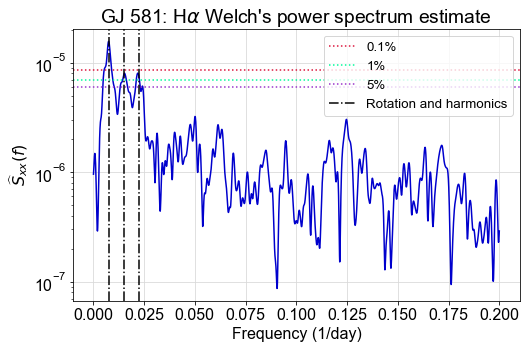

In [21]:
plt.figure(figsize=(8,5))
plt.semilogy(rv_ha.pow_coh_grid, rv_ha.y_series.Welch_pow, color='mediumblue')
plt.axhline(rv_ha.ypow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
plt.axhline(rv_ha.ypow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
plt.axhline(rv_ha.ypow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')

for s in [frot_measured, 2*frot_measured]:
    plt.axvline(s, color='k', ls='-.')
plt.axvline(3*frot_measured, color='k', ls='-.', label='Rotation and harmonics')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{xx}(f)$")
plt.title(r"GJ 581: H$\alpha$ Welch's power spectrum estimate")
plt.legend(loc='upper right', fontsize='small')
plt.grid(color='0.85')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


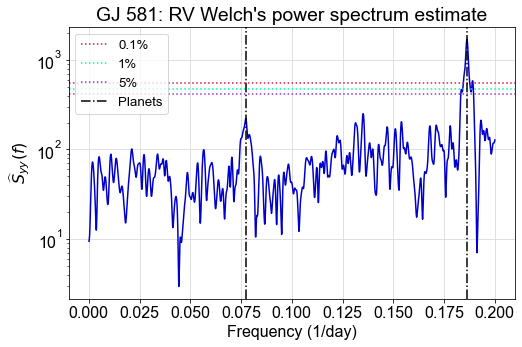

In [22]:
plt.figure(figsize=(8,5))
plt.semilogy(rv_ha.pow_coh_grid, rv_ha.x_series.Welch_pow, color='mediumblue')
plt.axhline(rv_ha.xpow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
plt.axhline(rv_ha.xpow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
plt.axhline(rv_ha.xpow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')
plt.axvline(planets[0], color='k', ls='-.', label='Planets')
plt.axvline(planets[1], color='k', ls='-.')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{yy}(f)$")
plt.title(r"GJ 581: RV Welch's power spectrum estimate")
plt.legend(loc='upper left', fontsize='small')
plt.grid(color='0.85')